In [187]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from matplotlib import image

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
n_classes = len(class_names)

In [5]:
len(dataset)

68

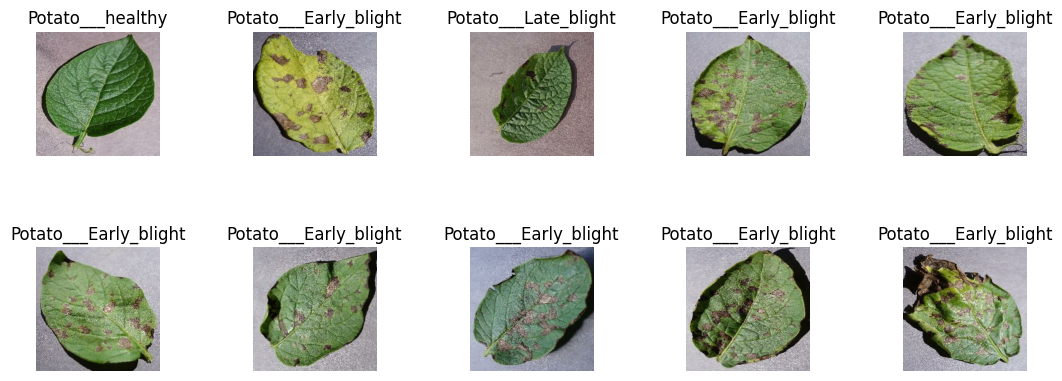

In [201]:
for image_batch, label_batch in dataset.take(1):
    fig = plt.figure(figsize=(12,5))
    #print(image_batch.shape)
    #print(label_batch.shape)
    for i in range(1,11):
        ax = plt.subplot(2,5,i)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
        plt.tight_layout(pad=5)
plt.savefig("images/samples.png")

80% training, 10% cross-val, 10% test

In [7]:
def get_dataset_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size) 

    return train_ds, val_ds, test_ds

In [8]:
train_ds, val_ds, test_ds = get_dataset_partitions(dataset)

In [9]:
#Setting up input pipeline optimization
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1.0/255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [12]:
#izmjeniti kasnije
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #tf.keras.Input(shape=input_shape),#, batch_size=BATCH_SIZE),

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D((2,2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

model.summary()

c:\Users\jom4n\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
             tf.keras.callbacks.ModelCheckpoint("models/model1.keras", verbose=1, save_best_only=1)
            ]

In [ ]:
#Dodati ModelChekpoint, EarlyStopping i još možda koji callback
history = model.fit(
    train_ds, 
    epochs=2, 
    batch_size=BATCH_SIZE, 
    verbose=1, 
    validation_data=val_ds,
    callbacks=callbacks)

Epoch 1/2


54/54 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4247 - loss: 0.9513 - val_accuracy: 0.5359 - val_loss: 0.9037
Epoch 2/2
54/54 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.5729 - loss: 0.8623 - val_accuracy: 0.7031 - val_loss: 0.7203


In [15]:
history_df = pd.DataFrame(history.history)

<Figure size 1000x700 with 0 Axes>

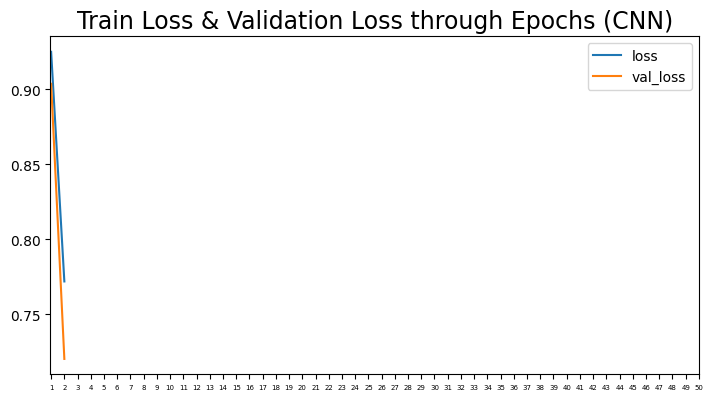

In [16]:
#Plotting loss through different epochs
fig = plt.figure(figsize=(10,7))
(history_df[['loss', 'val_loss']]).plot(figsize=(8,5))
plt.title("Train Loss & Validation Loss through Epochs (CNN)", fontsize=17)
plt.tight_layout(pad=4)
ticks = np.arange(0,EPOCHS)
plt.xticks(ticks=ticks, labels=[i+1 for i in ticks], fontsize=5)
plt.savefig("images/Loss_Val_Loss_CNN.png", bbox_inches="tight")
plt.show()

<Figure size 1000x700 with 0 Axes>

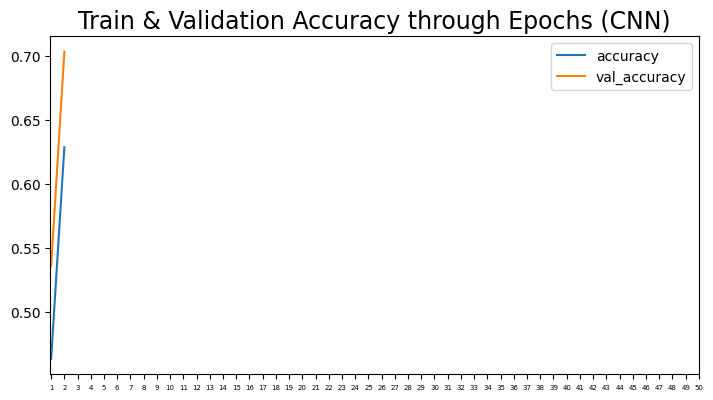

In [17]:
#Plotting accuracy through different epochs
fig = plt.figure(figsize=(10,7))
(history_df[['accuracy', 'val_accuracy']]).plot(figsize=(8,5))
plt.title("Train & Validation Accuracy through Epochs (CNN)", fontsize=17)
plt.tight_layout(pad=4)
ticks = np.arange(0,EPOCHS)
plt.xticks(ticks=ticks, labels=[i+1 for i in ticks], fontsize=5)
plt.savefig("images/Acc_Val_Acc_CNN.png", bbox_inches="tight")
plt.show()

In [18]:
#Usporediti prave oznake i predviđene, staviti vjerojatnost pokraj u zagradu i ispisati ju zelenim slovima ako je točno predvidilo, crveno inače

In [134]:
def predict(images_batch, model, class_names=class_names):
    
    predictions = model.predict(images_batch)
    predicted_classes = np.array([class_names[np.argmax(i)] for i in predictions])
    confidences = np.array([round(np.max(i), 2) for i in predictions])

    return predicted_classes, confidences
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


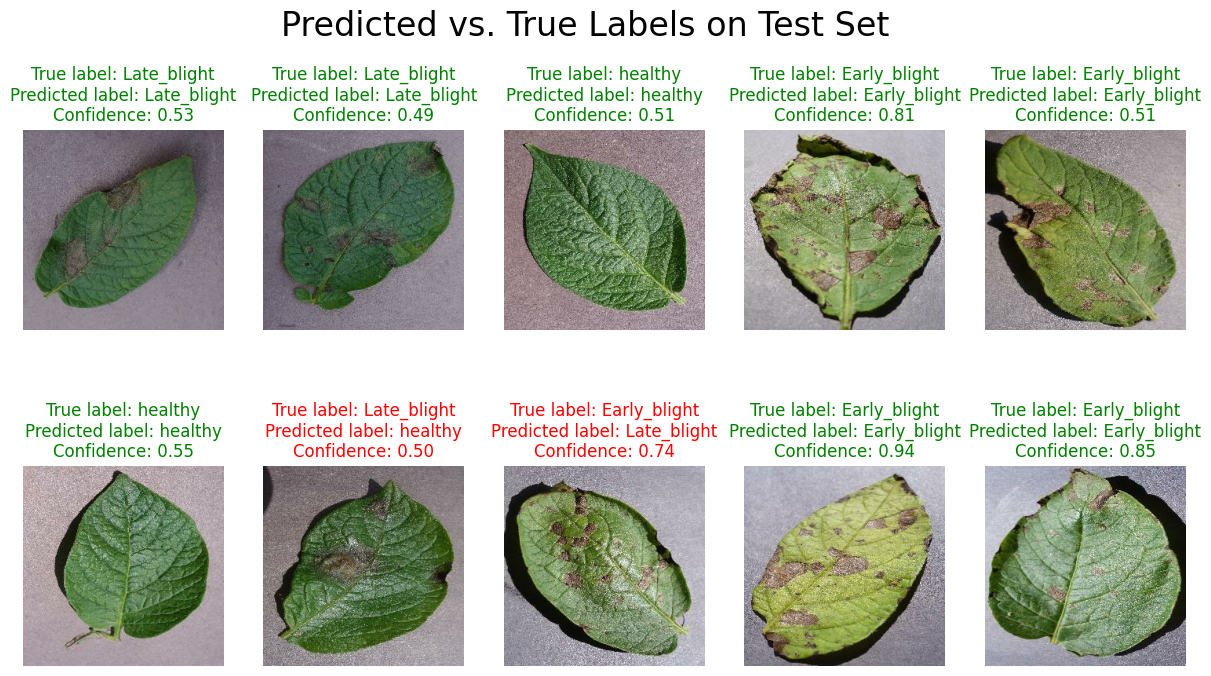

In [171]:
#Taking one batch of images and labels
for images_batch, labels_batch in test_ds.take(1):
    predicted_labels, confidences = predict(images_batch.numpy(), model)
    fig = plt.figure(figsize=(15,8))
    plt.suptitle("Predicted vs. True Labels on Test Set", fontsize=24)
    #Iterating through images and labels inside of one batch
    for i in range(10):
        image = (images_batch[i].numpy().astype('uint8'))
        true_label = class_names[labels_batch[i].numpy()]
        predicted_label = predicted_labels[i]
        confidence = confidences[i]

        #Plotting results
        ax = plt.subplot(2, 5, i+1)
        plt.imshow(image)
        plt.axis('off')
        #plt.tight_layout()
        col = "green" if predicted_label==true_label else "red"
        plt.title(f"True label: {true_label.split("___")[1]}\nPredicted label: {predicted_label.split("___")[1]}\nConfidence: {"%.2f" % confidence }", color=col)
plt.savefig("images/Test_Set.png", bbox_inches="tight")

In [200]:
#Saving model (incrementing versions)
model_version = max([int(os.listdir("models")[i].split(".")[0].split("l")[1]) for i in range (len(os.listdir("models")))])
new_model_version = model_version + 1
tf.keras.models.save_model(model, f"models/model{new_model_version}.keras")